In [34]:
import numpy as np
import pandas as pd

import emcee
import corner

import os
CWD = "/".join(os.getcwd().split("/")[:-2])

import matplotlib.pyplot as plt
%matplotlib inline

from funcs.model import full_model_2flares, aflare, calculate_angular_radius

import astropy.units as u
from astropy.constants import R_sun

import matplotlib 
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 

font = {'family' : 'courier',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

In [20]:
ID = 237880881#212035340 #100004076#
tstamp = '23_12_2019_13_28'

In [21]:
props = pd.read_csv(f"{CWD}/data/summary/everything.csv")
target = props[props.ID == ID].iloc[0]
R = target.Rstar *R_sun

In [22]:
inits = pd.read_csv(f"{CWD}/data/summary/inits.csv")
inits = inits[(inits.ID == str(ID)+"a")&(inits.date==tstamp)].iloc[0]
qlum = inits.qlum_erg_s *u.erg/u.s
Fth = inits.Fth * u.erg/u.cm**2/u.s
median = inits.median

In [23]:
lc = pd.read_csv(f"{CWD}/data/lcs/{tstamp}_{ID}.csv")

In [24]:
target

ID                            237880881
QCS                                   1
typ                                 slc
cadence_min                           2
mission                            tess
prefix                              TIC
origin                          generic
h_mission                          TESS
SpT                                  M5
view_start                         1331
view_stop                        1333.5
view_min                            560
view_max                            700
BJDoff                          2457000
tstart                           1331.7
ampl_min                            NaN
ampl_max                            NaN
RA                               19.528
Dec                            -62.9831
J                                 11.53
R                                   NaN
Gaia_G                          14.9796
vsini_kms                          14.4
e_vsini_kms                         2.6
Prot_d                          0.35125


In [38]:
# see here https://emcee.readthedocs.io/en/stable/tutorials/monitor/
filename = f"{CWD}/analysis/results/mcmc/{tstamp}_{target.ID}_MCMC.h5"
reader = emcee.backends.HDFBackend(filename)

#tau = reader.get_autocorr_time()
#burnin = int(2 * np.max(tau))
#thin = int(0.5 * np.min(tau))
burnin=10000
thin=15
ndim=9
samples = reader.get_chain(discard=burnin, flat=True, thin=thin)
log_prob_samples = reader.get_log_prob(discard=burnin, flat=True, thin=thin)
log_prior_samples = reader.get_blobs(discard=burnin, flat=True, thin=thin)

print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(samples.shape))
print("flat log prob shape: {0}".format(log_prob_samples.shape))
print("flat log prior shape: {0}".format(log_prior_samples.shape))


burn-in: 10000
thin: 15
flat chain shape: (82432, 9)
flat log prob shape: (82432,)


AttributeError: 'NoneType' object has no attribute 'shape'

In [39]:

#map phi_a_distr to t0_distr:
for i in [0,1]:
    samples[:, i] = np.interp(samples[:,i],lc.phi,lc.t)

# convert theta_f to degrees
samples[:, 2] = samples[:, 1] / np.pi * 180.

# convert FWHM to days
for i in [5,6]:
    samples[:, i] = samples[:, i]/2/np.pi*target.Prot_d 

# convert i to degrees
samples[:, -2] = samples[:, -2] / np.pi * 180.

# map phi0 to phi_peak longitude, still call it phi0
samples[:, -1] = (samples[:, 0]%(2.*np.pi) - samples[:, -1]) / np.pi * 180. # 0 would be facing the observer





# Plots
### Plot the full chain

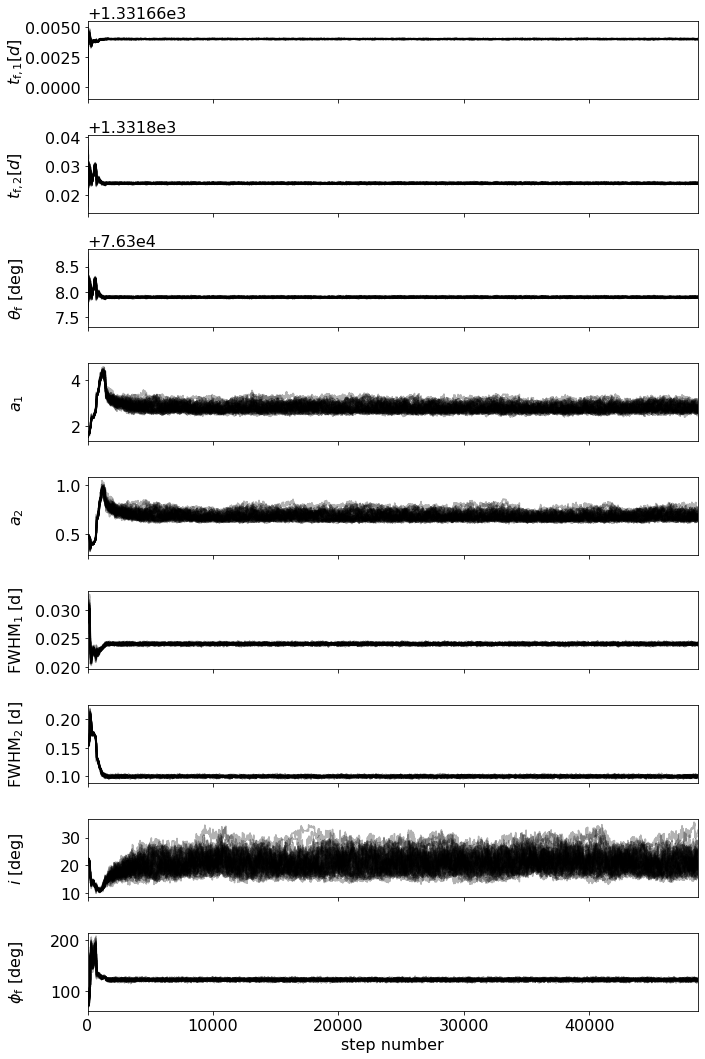

In [43]:
fig, axes = plt.subplots(9, figsize=(10, 15), sharex=True)

multi_samples = reader.get_chain()
walkers = multi_samples.shape[1]
steps = multi_samples.shape[0]
nparam = multi_samples.shape[2]
# -----------------------------------------------------------------------
#map phi_a_distr to t0_distr:
for i in [0,1]:
    multi_samples[:, :,i] = np.interp(multi_samples[:,:,i],lc.phi,lc.t)

# convert theta_f to degrees
multi_samples[:, :,2] = multi_samples[:,:, 1] / np.pi * 180.

# convert FWHM to days
for i in [5,6]:
    multi_samples[:,:, i] = multi_samples[:,:, i]/2/np.pi*target.Prot_d 

# convert i to degrees
multi_samples[:,:, -2] = multi_samples[:,:, -2] / np.pi * 180.

# map phi0 to phi_peak longitude, still call it phi0
multi_samples[:,:, -1] = (multi_samples[:, :,0]%(2.*np.pi) - multi_samples[:,:, -1]) / np.pi * 180. # 0 would be facing the observer
# -----------------------------------------------------------------------
labels = [r'$t_\mathrm{f,1} [d]$', r'$t_\mathrm{f,2} [d]$',
          r'$\theta_\mathrm{f}$ [deg]', 
          r'$a_1$', r'$a_2$',
          r'FWHM$_1$ [d]', r'FWHM$_2$ [d]', 
          r'$i$ [deg]',
          r"$\phi_\mathrm{f}$ [deg]"]
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10) 
for j in range(ndim):
    ax = axes[j]
    ax.plot(multi_samples[:, :, j], "k", alpha=0.3)
    ax.set_xlim(0, len(multi_samples))
    ax.set_ylabel(labels[j])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
plt.tight_layout()
plt.savefig(f"{CWD}/analysis/plots/flarefit/{tstamp}_{target.prefix}{target.ID}_chain.png",dpi=300)

### Corner plot

(1236896, 9)


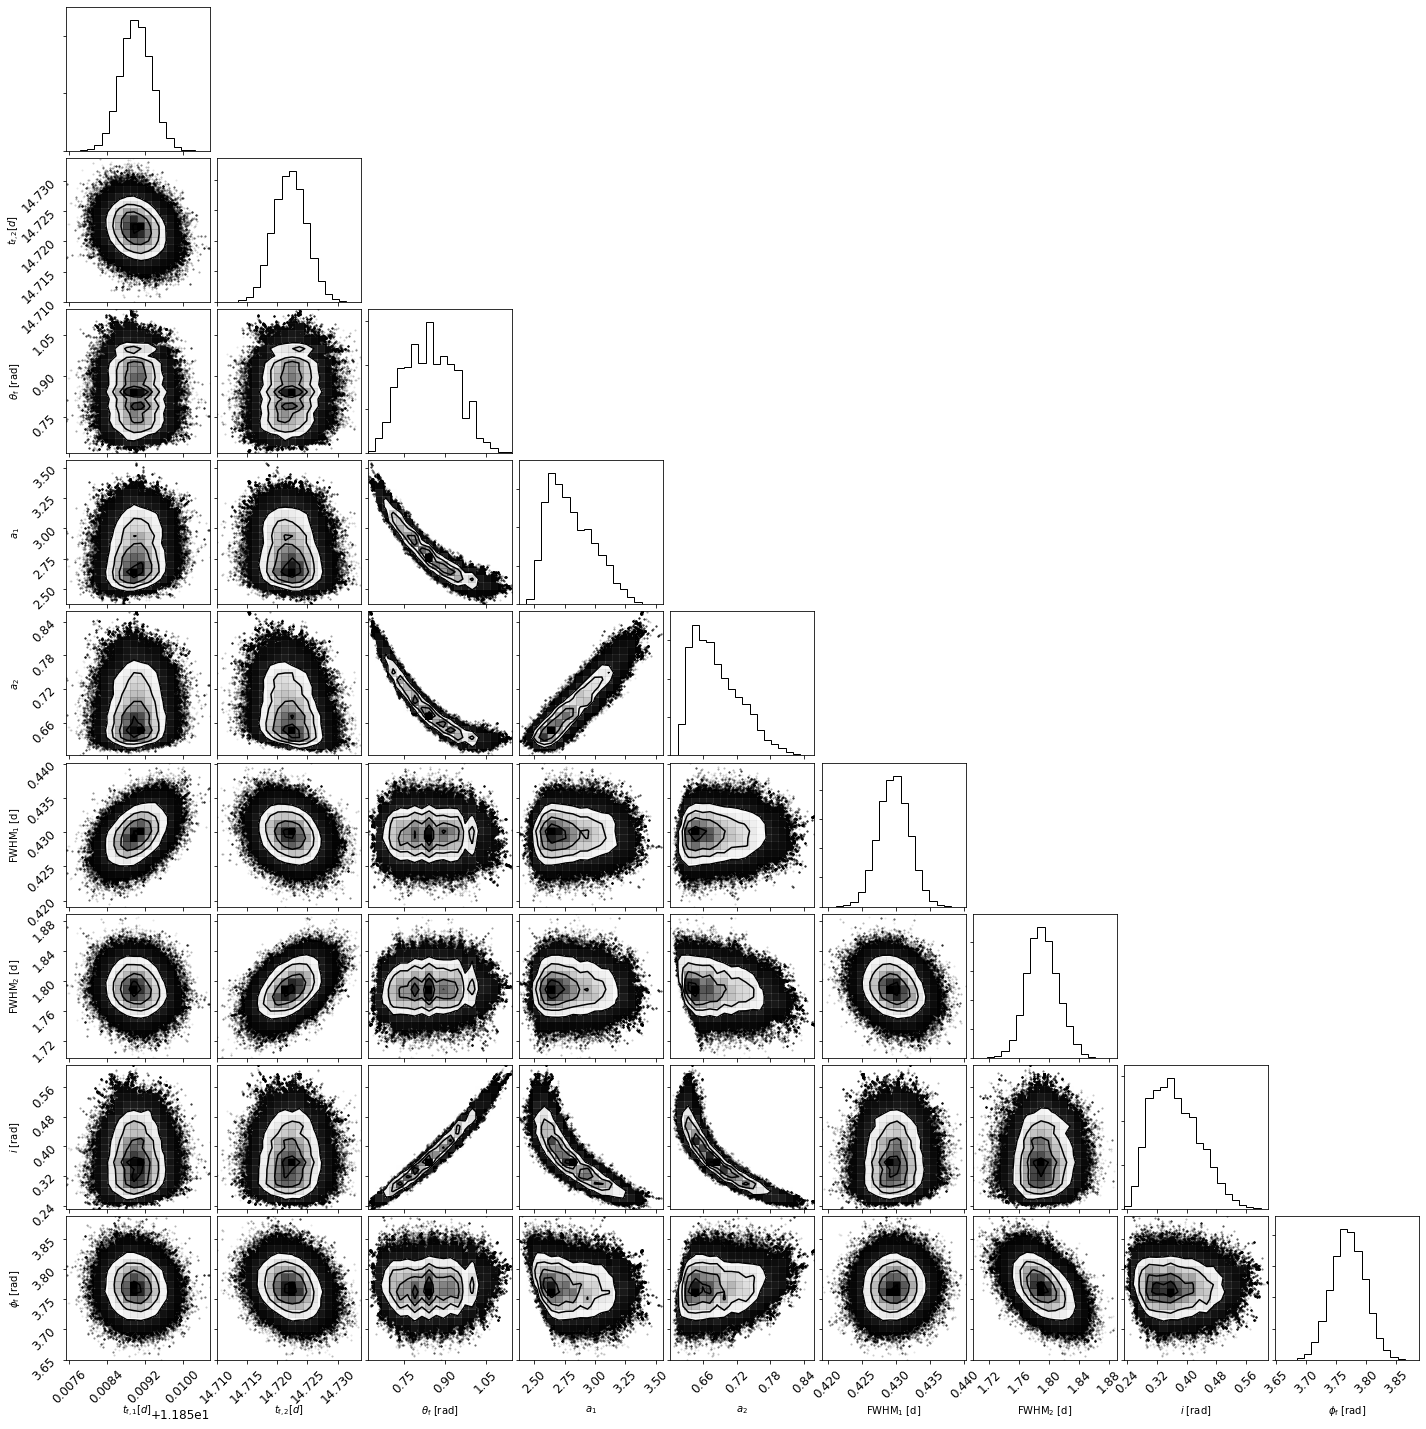

In [29]:
fig = corner.corner(samples, labels=labels)
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
plt.savefig(f"{CWD}/analysis/plots/flarefit/{tstamp}_{target.prefix}{target.ID}_corner_disc{burnin}.png",dpi=300)

In [59]:
0.37 / np.pi *180

20.053522829578814

### Retrieve and plot some example fits to the data from the chain

findfont: Font family ['courier'] not found. Falling back to DejaVu Sans.


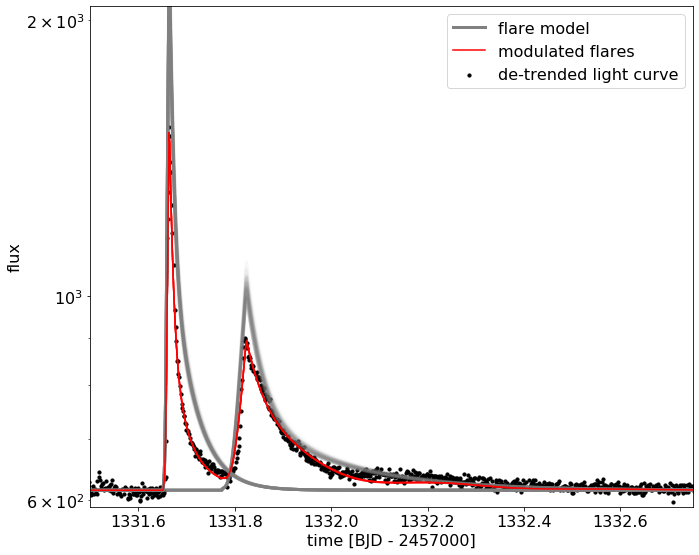

In [35]:
N = 50
phi = lc.phi.values
time = lc.t
flux = lc.flux.values
median = lc.median_[0]
inds = np.random.randint(len(flat_samples), size=N)
plt.figure(figsize=(10,8))
#plt.scatter(flck.time, flck.flux, s=1)
plt.scatter(time, flux, s=10, c="k", label=r"de-trended light curve")
#plt.errorbar(phi, flux, yerr=flux_err, fmt=".k", capsize=0)

for ind in inds:
    sample = flat_samples[ind]
    phi_a1, phi_a2, theta_a, a1, a2, fwhm1, fwhm2, i, phi0 = sample
    plt.plot(time, aflare(phi, phi_a1, fwhm1, a1*median)+ median, c="grey", alpha=0.05, linewidth=3)
    plt.plot(time, aflare(phi, phi_a2, fwhm2, a2*median)+ median, c="grey", alpha=0.05, linewidth=3)
    plt.plot(time, full_model_2flares((phi_a1,phi_a2), theta_a, (a1,a2), (fwhm1,fwhm2), i, phi0=phi0,
               phi=phi, num_pts=50, qlum=qlum,
               Fth=Fth, R=R, median=median), c="r", alpha=0.05,)
    

plt.plot(time, aflare(phi, phi_a1, fwhm1, a1*median)+ median, c="grey", alpha=1, linewidth=3,label="flare model")
plt.plot(time, full_model_2flares((phi_a1,phi_a2), theta_a, (a1,a2), (fwhm1,fwhm2), i, phi0=phi0,
           phi=phi, num_pts=50, qlum=qlum,
           Fth=Fth, R=R, median=median), c="r", alpha=1, label="modulated flares")
#plt.plot(phi, flare+median, c="r"|,linewidth=1)
plt.legend(fontsize=16)
plt.xlabel(f"time [BJD - {target.BJDoff}]",fontsize=16)
plt.ylabel("flux",fontsize=16);
plt.yscale("log")
plt.ylim(590,2070)
plt.xlim(1331.5,1332.75)
plt.tight_layout()
plt.savefig(f"{CWD}/analysis/plots/flarefit/{tstamp}_{target.prefix}{target.ID}_flarefit_{N}retrievals.png",dpi=300)

# Results
### Percentiles of fitted parameters

In [33]:
percentiles = [16,50,84]
#phi_a1, phi_a2, theta_a, a1, a2, fwhm1, fwhm2, i, phi0 
t01_p, t02_p, theta_a_p, a1_p, a2_p, fwhm1_p, fwhm2_p, i_p, phi0_p = map(lambda v: (v[0], v[1], v[2]),
                                                   zip(*np.percentile(samples, percentiles,
                                                       axis=0)))


# Write percentiles to file
with open(f"{CWD}/analysis/results/mcmc/mcmcoutput.csv","a") as f:
    #Add more lines here
    
    # First flare
    out = f"{tstamp},{target.ID}a,{burnin},{steps},{walkers},{nparam},"
    firstout = f"date,ID,burnin,steps,walkers,nparam,"
    for i in ['t01_p', 'theta_a_p', 'a1_p', 'fwhm1_p', 'i_p', 'phi0_p']:
        firstout += f"{i}{percentiles[0]},{i}{percentiles[1]},{i}{percentiles[2]},"
    for i in [t01_p, theta_a_p, a1_p, fwhm1_p, i_p, phi0_p ]:
        out += f"{i[0]},{i[1]},{i[2]},"
    out += "\n"
    firstout += "\n"
    f.write(firstout)
    f.write(out)
    
    # Second flare
    out = f"{tstamp},{target.ID}b,{burnin},{steps},{walkers},{nparam},"
    firstout = f"date,ID,burnin,steps,walkers,nparam,"
    for i in ['t02_p', 'theta_a_p', 'a2_p', 'fwhm2_p', 'i_p', 'phi0_p']:
        firstout += f"{i}{percentiles[0]},{i}{percentiles[1]},{i}{percentiles[2]},"
    for i in [t02_p, theta_a_p, a2_p, fwhm2_p, i_p, phi0_p ]:
        out += f"{i[0]},{i[1]},{i[2]},"
    out += "\n"
    firstout += "\n"
    f.write(firstout)
    f.write(out)

### What are the most likely angular radii of the active region?

In [87]:
rads1=[]
for a in flat_samples[:,3]:
#func = np.vectorize(calculate_angular_radius)#(Fth, flat_samples[:,2], qlum, R, 0, 0, np.pi/2, phi0=0)
    rads1.append(calculate_angular_radius(Fth, a, qlum, R))
    
rads2=[]
for a in flat_samples[:,4]:
#func = np.vectorize(calculate_angular_radius)#(Fth, flat_samples[:,2], qlum, R, 0, 0, np.pi/2, phi0=0)
    rads2.append(calculate_angular_radius(Fth, a, qlum, R))

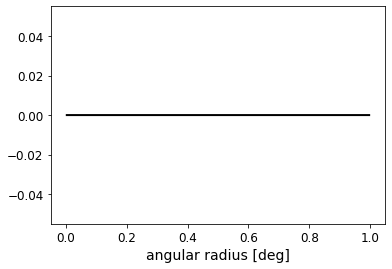

In [86]:
plt.hist(rads2,bins=1000, histtype="step",color="k",linewidth=2);
plt.xlabel("angular radius [deg]")
plt.savefig(f"{CWD}/analysis/plots/flarefit/{tstamp}_{target.prefix}{target.ID}_active_region_radii_a2.png",dpi=300)

### Equivalent duration distribution

In [50]:
def calculate_ED(t, t0, dur, ampl, median):
    x = t * 60.0 * 60.0 * 24.0
    return np.sum(np.diff(x) * aflare(t, t0, dur, ampl)[:-1]) / (dur * 6 * median)

In [65]:
t0_distr = samples[:,0]
a_distr = samples[:,2]
fwhm_distr = samples[:,3]
l=len(t0_distr)
tl = len(lc.t.values )
ED_distr = []
for i in range(l):
    ED_distr.append(calculate_ED(lc.t.values, t0_distr[i], fwhm_distr[i], a_distr[i]*median, median ))
    #print(lc.t.values, t0_distr[i], fwhm_distr[i], a_distr[i]*median, median )

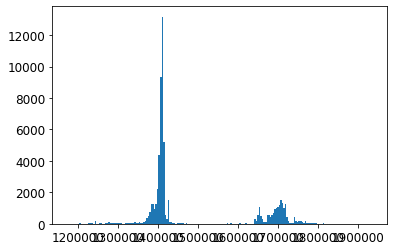

In [66]:
ED_distr = np.array(ED_distr)
plt.hist(ED_distr,bins=200);
#plt.xlim(0,8000)
#plt.yscale("log")

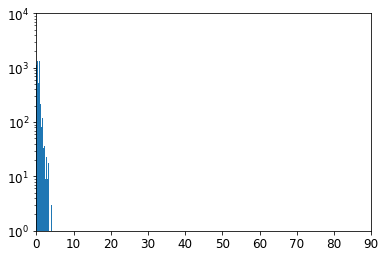

In [67]:
plt.hist(samples[:,1]/np.pi*180,bins=200);
plt.xlim(0,90)
plt.ylim(1,1e4)
plt.yscale("log")

In [46]:
74.5%24

2.5